# EE932: Programmming Assignment 3
**Name**: Venkateswar Reddy Melachervu </br>
**Roll No.**: 23156022


# Cliff Walking 

Through this gridworld exercise we will compare Sarsa and Q-learning algorithms, highlighting the difference between them. Consider the Cliff World shown in the assignment. This is a standard undiscounted, episodic task, with start and goal states, and the usual actions causing movement up, down, right, and left. Reward is −1 on all transitions except those into the the region marked “The Cliff.” Stepping into this region incurs a reward of −100 and sends the agent instantly back to the start. There are totally 48 states numbered from 0 to 47

In [1]:
#!pip install pygame
#!pip install "gymnasium[toy-text]"

In [1]:
# Import
%matplotlib inline
import gymnasium as gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys
import time
from matplotlib import pyplot as plt
from collections import defaultdict
matplotlib.style.use('ggplot')

In [2]:
print('Welcome to EE-932 Programming Assignment-3 - Cliff Walking - Solution by Roll No.23156022 - Venkateswar Reddy Melachervu')
print('In this assignment, we will compare Sarsa and Q-learning algorithms, highlighting the difference between them through this gridworld of 4x12')
print('This program builds on openAI\'s gymnasium(toy-text) and pygame.')
# Create environment
# change render mode to 'ansi' to run the algorithm fast
# env = gym.make('CliffWalking-v0', render_mode='human')
env = gym.make('CliffWalking-v0', render_mode='ansi')
env.reset()
env.render()  
time.sleep(0.1)

Welcome to EE-932 Programming Assignment-3 - Cliff Walking - Solution by Roll No.23156022 - Venkateswar Reddy Melachervu
In this assignment, we will compare Sarsa and Q-learning algorithms, highlighting the difference between them through this gridworld of 4x12
This program builds on openAI's gymnasium(toy-text) and pygame.


In [3]:
env.step(1)
# state, action, terminated?, truncated?, info

(36, -100, False, False, {'prob': 1.0})

In [4]:
# Allowed Actions
# 0 => UP
# 1 => Right
# 2 => Down
# 3 => Left

# Let us take a few actions and get familiar with the environment
print('We started here')
env.reset()
env.render()

# Let us take up first
print('Let us take UP action')
env.step(0)
env.render()

# Now lets take another UP
print('Another UP action')
env.step(0)
env.render()

# Now lets take two rights
print('Two Right actions')
env.step(1)
env.step(1)
env.render()

# Now one left
print('One Left action')
env.step(3)
env.render()

env.close()

We started here
Let us take UP action
Another UP action
Two Right actions
One Left action


In [5]:
# A helper function for plotting the comparision graphs between two or more algorithms. 
# You need not understand this code.
# Just look at the next cell to understand how to use it.

def plot_episode_reward(a, stats, smoothing_window=10, noshow=False):
    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(7,3))
    for stat in stats:
        rewards_smoothed = pd.Series(stat).rolling(smoothing_window, min_periods=smoothing_window).mean()
        plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    plt.legend(a)
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

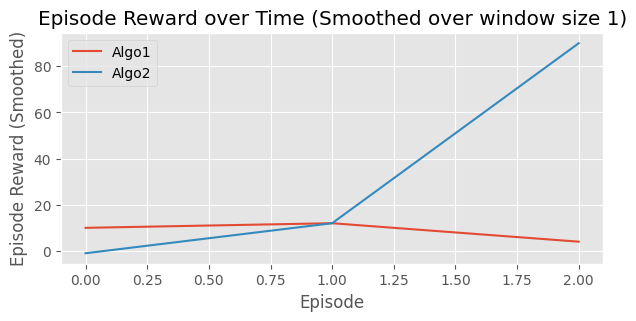

In [6]:
# Demo for using Plotting helper function
# Here we are comparing two algorithms which were run for 3 episodes each. 

stats_algo1= [10,12,4]    #The return obtained in each episode for Algo1
stats_algo2= [-1,12,90]    #The return obtained in each episode for Algo2

#Plotting the comparision
#Here the last argument is to smoothen the plot. Use higher values such as 10 for smooth plots.

plot_episode_reward(['Algo1','Algo2'],[stats_algo1,stats_algo2],smoothing_window=1)  

### Epsilon-greedy policy from Q-function and epsilon

Helper function to create epsilon-greedy policy based on a given Q-function and epsilon.

In [7]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the state/observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        
        if type(observation) is tuple:
            best_action = np.argmax(Q[observation[0]])
        else:
            best_action = np.argmax(Q[observation])
            
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [8]:
# How to use make_epsilon-greedy_policy function
# consider two states s1, s2 and 3 actions {0,1,2} in each state

Q={'s1':[0.5, 2, 3], 's2':[-0.1, 4 , 3]}  # A sample Q-function Q(s,a) for each state-action pair

# For this example it is clear that for state s1, action 2 is the greedy action.
# For state s2, action 1 is the greedy action

"""
If we want an epsilon greedy policy with epsilon=0.3, then the best action
should get a probility = 0.7 + 0.3/3 = 0.8
other action with probability = 0.3/3 = 0.1

"""

# Let us verify this using our make_epsilon-greedy_policy function

policy_fn = make_epsilon_greedy_policy(Q, epsilon=0.3, nA=3)

print("The epsilon-greedy policy at state s1 is ", policy_fn('s1'))
print("The epsilon-greedy policy at state s2 is ", policy_fn('s2'))

The epsilon-greedy policy at state s1 is  [0.1 0.1 0.8]
The epsilon-greedy policy at state s2 is  [0.1 0.8 0.1]


***

## Q1.1 SARSA algorithm

Implement the SARSA algorithm using the following function template that retunts a tuple containing the optimal action value function and training statistics (array of cumulatetive rewards at each episode) **[3.5 Marks]**

In [9]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.ones(env.action_space.n))
    
    # Keeps track of cumulative reward at each episode 
    stats = []
    print('Beginning SARSA Learning...')
    sys.stdout.flush()
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 10 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
        # Reset the environment and pick the first action
        state = env.reset()[0]
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
        total_reward=0
        
        # One step in the environment
        for t in itertools.count():
            # Generate the policy we're following from action value function
            policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
            
            # Select an action at the current state and take a step
            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward
            
            # Pick the next action
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            # TD Update: SARSA 
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_error= td_target - Q[state][action]
            Q[state][action] += alpha * td_error
                      
            # break the loop if episode terminates
            if done:
                break
            # update the action and state variables
            action = next_action
            state = next_state
        
        # store the cumulative episode reward
        stats.append(total_reward)
    
    return Q, stats

Beginning SARSA Learning...
Episode 200/200.

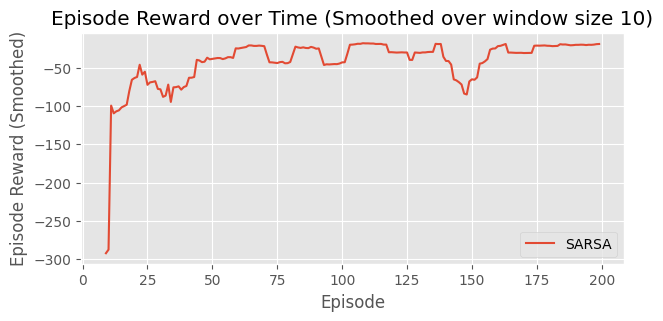

In [28]:
episodes = 200
Q_sarsa, stats_sarsa = sarsa(env, episodes, epsilon=0.1)
plot_episode_reward(['SARSA'],[stats_sarsa])

## Q1.2 Q-Learning algorithm

Implement the Q-Learning algorithm using the following function template that retunts a tuple containing the optimal action value function and training statistics (array of cumulatetive rewards at each episode) **[3.5 Marks]**

In [11]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
        target_rollout_stats is an EpisodeStats object with two numpy arrays for target_rollout_episode_lengths and target_rollout_episode_rewards.
    """
    
    # The final action-value function.
    # Initialize a nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of cumulative reward at each episode 
    stats = []
    count = 0
    print('Beginning Q-Learning...')
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 10 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
        
        # Reset the environment
        state = env.reset()[0]        
        
        # One step in the environment
        total_reward = 0
        for t in itertools.count():
            # The policy we're following
            policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
            
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward

            # TD Update: Q-Learning
            td_target = reward + discount_factor*(Q[next_state].max())
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)),p=next_action_probs)
            td_target_sarsa = reward + discount_factor * Q[next_state][next_action]
            td_diff = td_target - td_target_sarsa

            if td_diff > 1e-15:
                count += 1

            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alpha * td_error
            
            # break the loop if episode terminates
            if done:
                break 
            
            # update the state
            state = next_state
        
        # store the cumulative episode reward
        stats.append(total_reward)
    if count > 0:
        print('\nSARSA and TD Q-learning are not identical - in compute')
    else:
        print('\nSARSA and TD Q-learning are identical - in compute')
    return Q, stats

### Comparison and Generating Plots 
Plotting the reward over episodes for both SARSA and Q-Learning

Beginning Q-Learning...
Episode 200/200.
SARSA and TD Q-learning are not identical - in compute
Beginning SARSA Learning...
Episode 200/200.

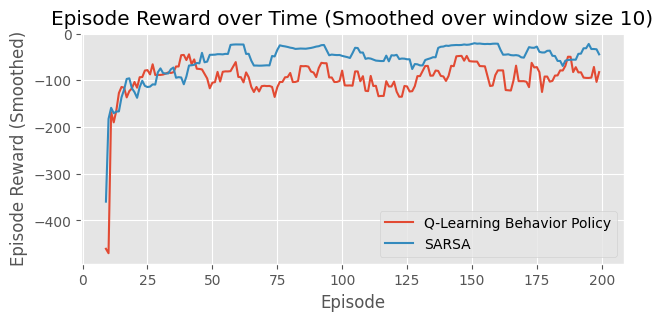

In [31]:
episodes = 200
Q_q, stats_q = q_learning(env, episodes, epsilon=0.2)
Q_sarsa, stats_sarsa = sarsa(env, episodes, epsilon=0.2)
plot_episode_reward(['Q-Learning Behavior Policy','SARSA'],[stats_q,stats_sarsa])

## Before we go on to visualize the policies generated by two TD methods answer the following questions:

#### Q2. Why is Q-learning considered an off-policy control method? **[2 Marks]** <br>
#### Answer: Q-learning is considered an off-policy control method. This is because it learns the value of the optimal policy independent of the agent's actions achieved by using the greedy policy derived from the Q-values for updating the Q-values, even though the agent may be following a different behavior policy during learning. <br><br>
#### Q3. Which algorithm takes a more conservative path? **[1 Marks]** <br>
#### Answer: Since SARSA updates its Q-values using the actual action taken by the agent (on-line policy), which might include exploratory (ε-greedy) actions, SARSA tends to be more conservative. This means that SARSA takes into account the potential risks of the exploratory actions, leading to more cautious learning and potentially safer policies. Q-learning is an off-policy algorithm, meaning it updates its Q-values using the assumption that the agent always takes the optimal action (max) in the next state, regardless of the agent’s current policy. This tends to make Q-learning more aggressive or optimistic, as it updates its Q-values based on the assumption of following the optimal policy in the future, even if the current policy is exploratory.<br> <br>
#### Q4. **(Bonus)** Suppose while learning the action selection is greedy. Is Q-learning then exactly the same algorithm as Sarsa? Will they make exactly the same action selections and weight updates? **[2 Marks]**
#### Answer: When using a greedy policy, the agent always selects the action with the highest Q-value. This means both SARSA and Q-learning will choose the same actions if their Q-values are initialized identically and updated synchronously. However, their Q-value updates will still differ due to the inherent difference in their update rules. Therefore, even with a greedy policy, SARSA and Q-learning are not exactly the same algorithm and will not make identical Q-value updates.<br>


### Visualizing the policy

In [32]:
# function to visualize policy over the environment
def render_policy(pi, mode='human', close=False):

    cliff_pose = [(3,1),(3,2),(3,3),(3,4),(3,5),(3,6),(3,7),(3,8),(3,9),(3,10)] # cliff states
    for s in range(48):
        position = np.unravel_index(s, (4,12))
        # print(self.s)
        if pi[position] == 0:
            output = " ↑ "
        elif pi[position] == 1:
            output = " → "
        elif pi[position] == 2:
            output = " ↓ "
        elif pi[position] == 3:
            output = " ← "

        if position == (3,11):
            output = " T "
        elif position in cliff_pose:
            output = " G "

        if position[1] == 0:
            output = output.lstrip()
        if position[1] == 12 - 1:
            output = output.rstrip()
            output += "\n"

        print(output, end="")
    print("\n")

In [36]:
# extracting greedy policy from the Q function
pi_sarsa = np.zeros(env.unwrapped.observation_space.n)
pi_q = np.zeros(env.unwrapped.observation_space.n)
for s in range(env.unwrapped.observation_space.n):
    pi_sarsa[s] = np.argmax(Q_sarsa[s]) 
    pi_q[s] = np.argmax(Q_q[s])
    
pi_sarsa = np.reshape(pi_sarsa, env.unwrapped.shape)
pi_q = np.reshape(pi_q, env.unwrapped.shape)

print('SARSA policy:')
render_policy(pi_sarsa)
print('Q-learning policy:')
render_policy(pi_q)

SARSA policy:
→  →  →  →  →  →  →  →  →  →  →  ↓
↑  ←  ↑  ↑  ↑  →  ↑  →  ↑  ↑  →  ↓
↑  ←  ←  ↑  ↑  →  ←  →  →  →  →  ↓
↑  G  G  G  G  G  G  G  G  G  G  T


Q-learning policy:
↑  ↓  ↑  →  →  ↑  →  →  ↓  →  →  ↓
→  →  →  ↓  →  →  ↓  →  ↓  →  ↓  ↓
→  →  →  →  →  →  →  →  →  →  →  ↓
↑  G  G  G  G  G  G  G  G  G  G  T


